In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
from sklearn.metrics import mean_squared_error
np.random.seed(42)
%matplotlib inline

## Import data

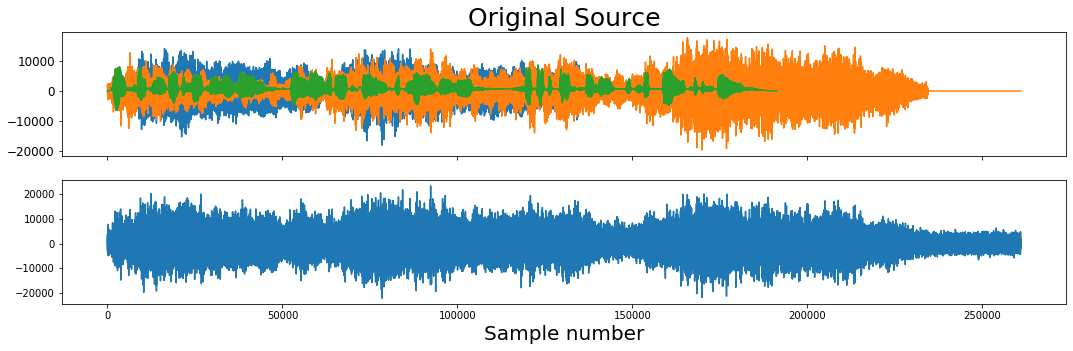

In [2]:
SR1, source1 = wavfile.read('beet.wav')
SR2, source2 = wavfile.read('beet9.wav')
SR3, source3 = wavfile.read('mike.wav')
MSR1, mix_source1 = wavfile.read('mixing1.wav')
MSR2, mix_source2 = wavfile.read('mixing2.wav')
MSR3, mix_source3 = wavfile.read('mixing3.wav')
n_samples=mix_source1.shape[0]
noise1 = 1.5*np.random.normal(loc=0.0,scale=1000, size=n_samples)
noise2 = 0.7*np.random.normal(loc=0.0, size=n_samples)
noise3 = 2.1*np.random.normal(loc=0.0, size=n_samples)
Source=np.asarray([source1,source2,source3])
X_=np.asarray([mix_source1+noise1,mix_source2,mix_source3])

fig, ax = plt.subplots(2, 1, figsize=[18, 5], sharex=True)
for i in range(len(Source)):
    ax[0].plot(Source[i])
ax[1].plot(X_[0])
ax[0].set_title('Original Source', fontsize=25)
ax[0].tick_params(labelsize=12)
ax[1].set_xlabel('Sample number', fontsize=20)
plt.show()

In [3]:
n_sample=mix_source1.shape[0]
n_sample

260890

## Preprocessing Data
### 1.Centering Data
Why ? This step aim to simplify the algorithm.
 \\\
How ? Let X - mean(x). We will get E(x) = E(s) = 0 \\
We can estimate original mean of data by inv(A)*mean(x)
\begin{equation}\mathbf{D}=\mathbf{X}-\mu=\left(\begin{array}{c}
\mathbf{d}_{1} \\
\mathbf{d}_{2} \\
\vdots \\
\mathbf{d}_{n}
\end{array}\right)=\left(\begin{array}{c}
\mathbf{x}_{1}-\mu \\
\mathbf{x}_{2}-\mu \\
\vdots \\
\mathbf{x}_{n}-\mu
\end{array}\right)\end{equation}

In [4]:
# Centering Data
def center(X):
    center=np.mean(X,axis=1,keepdims=True)
    X_center=X-center
    return X_center
X_center=center(X_)
print(X_center)

[[ 1648.48818668  1261.0205054   2001.94976431 ... -1280.77243586
   1151.72368133  1195.58273022]
 [  -81.93409483   233.06590517    -8.93409483 ...  -865.93409483
   -863.93409483  -865.93409483]
 [ 2198.69185864  3199.69185864  2427.69185864 ...  -277.30814136
   -275.30814136  -276.30814136]]


## Whitened Data
Goals of this step are:
+ Decorrelation: Transforming signals into uncorrelated signals
+ Scaling: Rescale signals to have Variance equal 1
\begin{equation}\tilde{\mathbf{x}}=\mathbf{E D}^{-1 / 2} \mathbf{E}^{\mathrm{T}} \mathbf{x}\end{equation}
\begin{equation}\text{E is orthogonal matrix of eigenvector of covariance matrix}\end{equation}
\begin{equation}\text{D is diagonal matrix of eigenvalue of covariance matrix}\end{equation}

In [5]:
def white(X):
#Calculate covariance matrix of X
    covariance=np.cov(X)
#Calculate eigenvalue and eigenvector
    d, E = np.linalg.eigh(covariance)
    D = np.diag(d)
#Whiten data
    x_white=np.dot(E,np.dot(np.sqrt(np.linalg.inv(D)),np.dot(E.T,X)))
    return x_white
X_white=white(X_center)
print(X_white)

[[ 0.45837666  0.04793575  0.57561422 ... -0.38374346  0.77829833
   0.79984837]
 [-0.593013   -0.37769609 -0.637415   ... -0.29965326 -0.81732287
  -0.82797134]
 [ 0.38894677  0.71604093  0.39390182 ...  0.19403384 -0.18957409
  -0.19662211]]


In [6]:
#Check data after preprocessing
print(np.round(np.cov(X_white)))
print(np.round(np.mean(X_white)))

[[ 1.  0. -0.]
 [ 0.  1.  0.]
 [-0.  0.  1.]]
0.0


## Apply Fast ICA algorithm for preprocessing data
After preprocessing our data, we will apply Fast ICA algorithm to get independent component: 
\\

Steps to apply Fast ICA algorithm to data:
1. Give a random initial value for mixing matrix W
2. Calculate new mixing matrix W follow this formula:
\begin{equation}g(w^TX)=\tanh \left(W^T X\right)\space\space g'(W^TX)=1-\tanh^2 \left(W^T X\right)\end{equation}
\begin{equation}\mathbf{w}^{+}=E\left\{\mathbf{x} g\left(\mathbf{w}^{\mathrm{T}} \mathbf{x}\right)\right\}-E\left(g^{\prime}\left(\mathbf{w}^{\mathrm{T}} \mathbf{x}\right)\right\} \mathbf{w}\end{equation}
3. Normalize W follow this formula:
\begin{equation}\mathbf{w}=\mathbf{w}^{+} /\left\|\mathbf{w}^{+}\right\|\end{equation}
4. Check if W has converged or not, if not we will repeat steps 2,3. If W is converged stop the algorithm.

In [7]:
#Define g and g' function.
def g(X):
    g_x=np.tanh(X)
    return g_x
def g_d(X):
    g_d_x=1-(np.tanh(X))**2
    return g_d_x

In [8]:
#Calculate new mixing matrix W
def new_w(w, X):
    w_new = (X * g(np.dot(w.T, X))).mean(axis=1) - g_d(np.dot(w.T, X)).mean() * w

    w_new /= np.sqrt((w_new ** 2).sum())

    return w_new

In [9]:
def Fastica(X, iterations,n_components=-1, tolerance=1e-5):
    if n_components < 1 :
        n_components = X.shape[0]
#Create random intial value for w
    W = np.zeros((n_components, n_components), dtype=X.dtype)

    for i in range(n_components):
        
        w = np.random.rand(n_components)
#Calculate and update new value for w        
        for j in range(iterations):
            
            w_new = new_w(w, X)
#Decorrelate output when use fastICA for many units.            
            if i > 1:
                w_new -= np.dot(np.dot(w_new, W[:i].T), W[:i])
#Check conrvege            
            distance = np.abs(np.abs((w * w_new).sum()) - 1)
            
            w = w_new
            
            if distance < tolerance:
                break
                
        W[i, :] = w
#Calculate ICs       
    S = np.dot(W, X)
    
    return S

In [22]:
Estimate_S=Fastica(X_white,n_components=3,iterations=1000)

## Visualize the result

Text(0.5, 0, 'ICs')

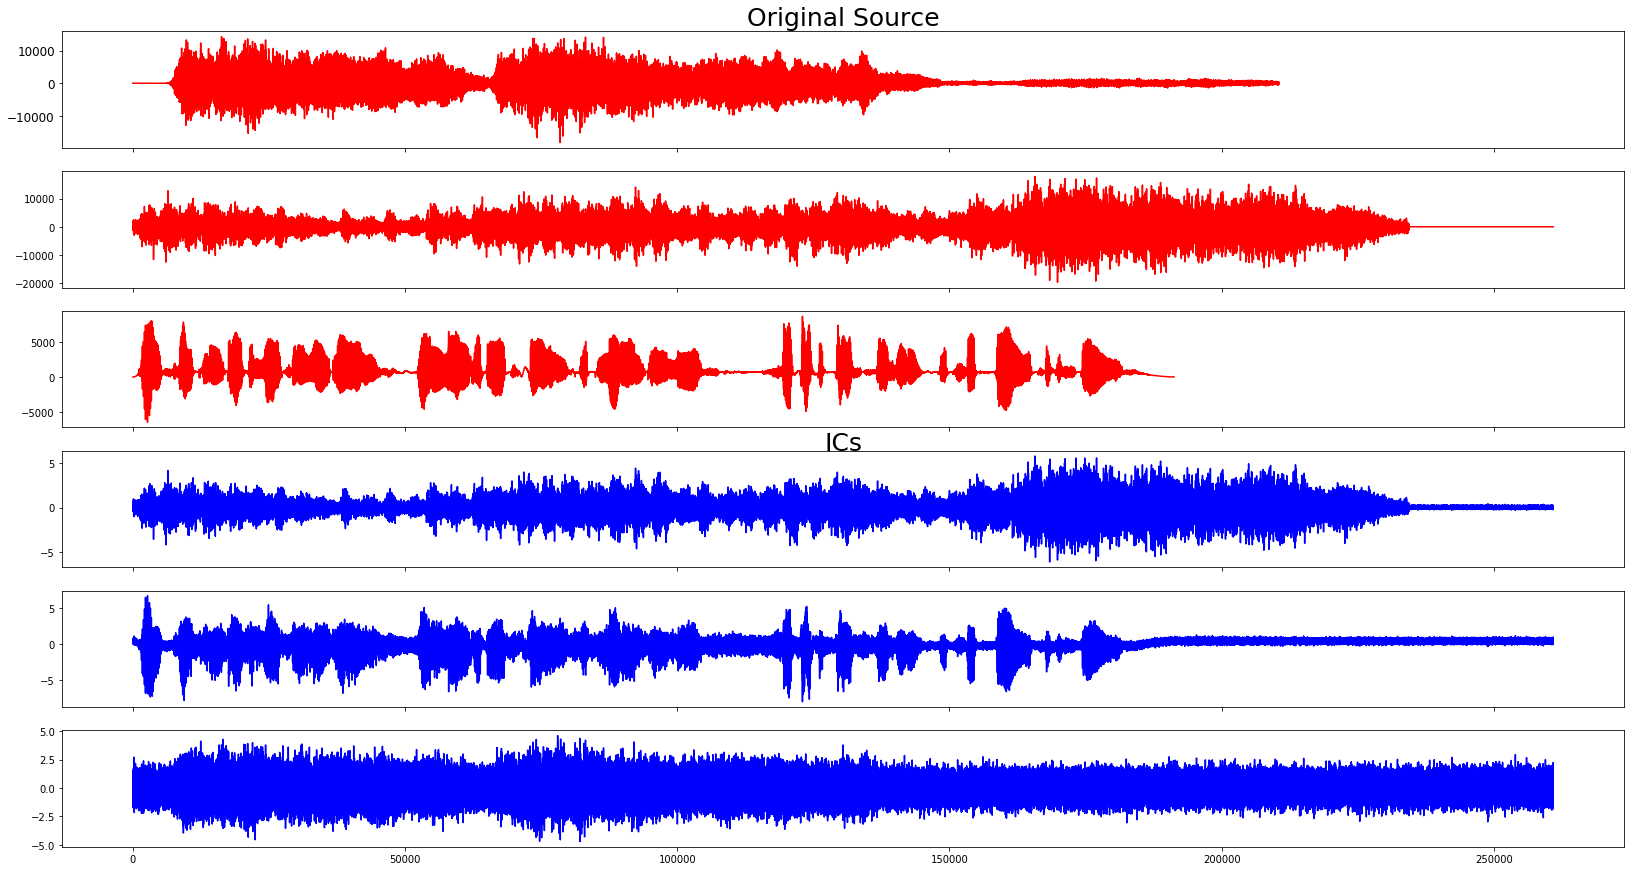

In [11]:
fig, ax = plt.subplots(6, 1, figsize=[28, 15], sharex=True)
ax[0].plot(source1,color='red')
ax[1].plot(source2,color='red')
ax[2].plot(source3,color='red')
ax[0].set_title('Original Source', fontsize=25)
ax[0].tick_params(labelsize=12)
ax[3].plot(Estimate_S[0],color='blue')
ax[4].plot(Estimate_S[1],color='blue')
ax[5].plot(Estimate_S[2],color='blue')
ax[2].set_xlabel('ICs', fontsize=25)


## Export wav file

In [12]:
wavfile.write('out1.wav', SR1, Estimate_S[0])
wavfile.write('out2.wav', SR1, Estimate_S[1])
wavfile.write('out3.wav', SR1, Estimate_S[2])

In [13]:
from sklearn.decomposition import FastICA
ica = FastICA(n_components=3,algorithm='deflation',max_iter=1000)
S_ = ica.fit_transform(X_.T)


In [14]:
S_=S_.T

Text(0.5, 0, 'ICs')

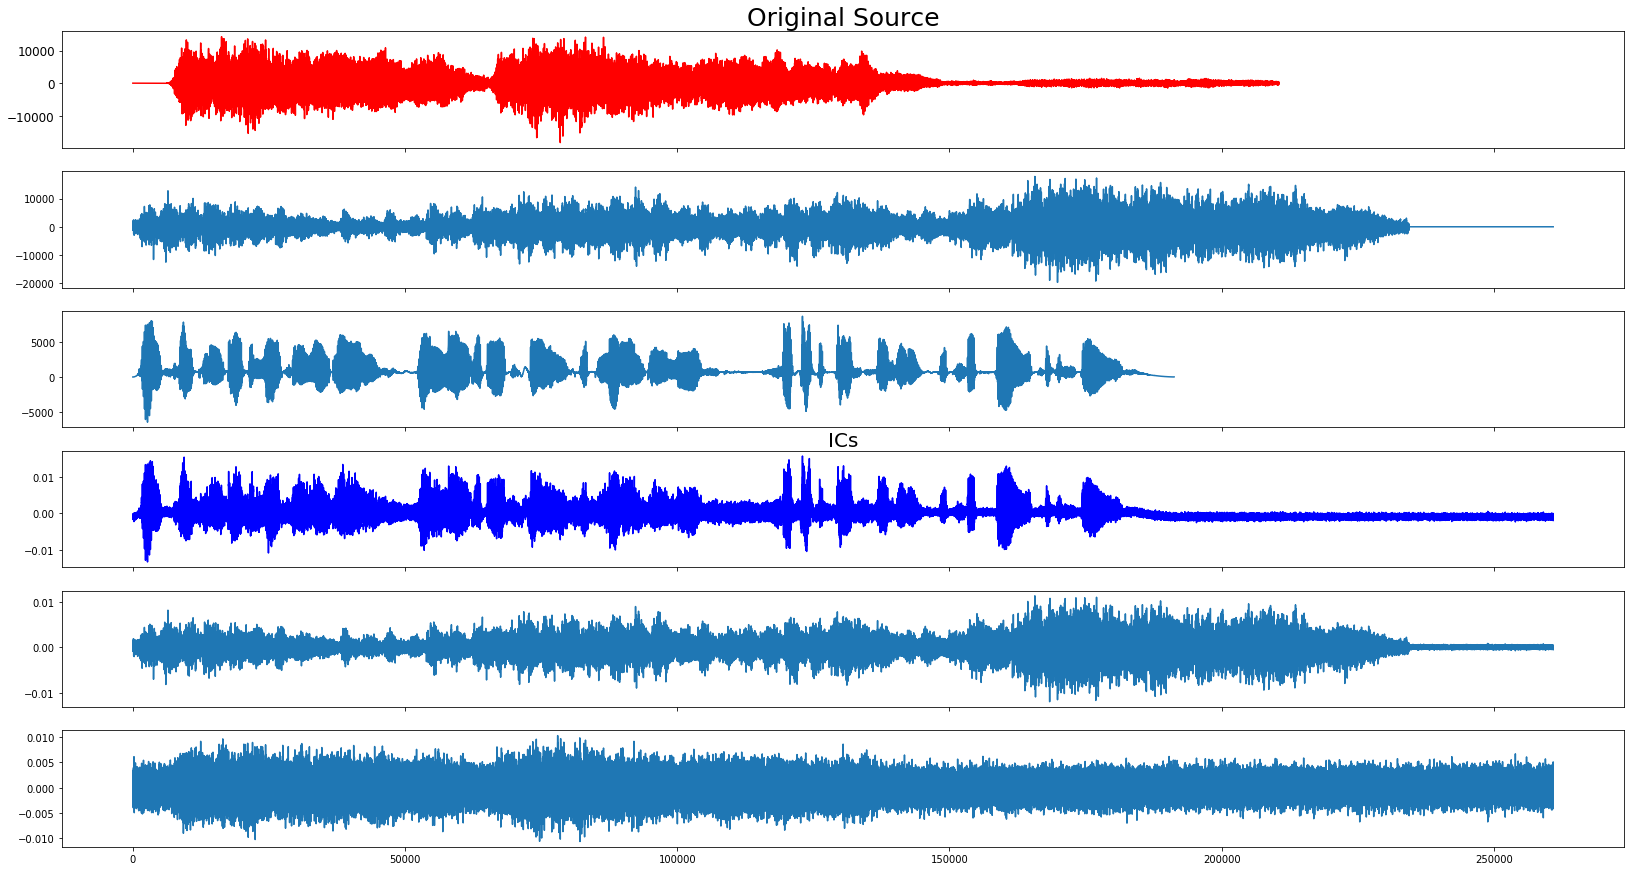

In [15]:
fig, ax = plt.subplots(6, 1, figsize=[28, 15], sharex=True)
ax[0].plot(source1,color='red')
ax[1].plot(source2)
ax[2].plot(source3)
ax[0].set_title('Original Source', fontsize=25)
ax[0].tick_params(labelsize=12)
ax[3].plot(S_[0],color='blue')
ax[4].plot(S_[1])
ax[5].plot(S_[2])
ax[2].set_xlabel('ICs', fontsize=20)


In [16]:
def logcosh(y, alpha=1.0):
    """Hàm logcosh

    G(y) = 1/alpha * log(cosh(alpha y))
    g(y) = tanh(alpha * y)
    g'(y) = alpha ( 1 - tanh^2(alpha * y))

    :param y: np.array - p dòng với n cột

    :return gy: g(y) - shape (p, n)
    :return g_y: g'(y) - shape (p, n)
    """
    y = alpha * y
    gy = np.tanh(y)
    g_y = alpha * (1 - gy*gy)
    return gy, g_y


In [17]:
def symetric_orthogonalization(W):
    """ Trực giao hóa đối xứng (xóa tương quan)

    :param W: np.array - p dòng với p cột
    :return W: np.array - p dòng với p cột
    """
    eigen_val, eigen_vec = np.linalg.eigh(np.dot(W, W.T))
    sqrt_wwt = (eigen_vec * (1. / np.sqrt(eigen_val))) @ eigen_vec.T
    return sqrt_wwt @ W


def fastica_symetric(X, g_func=logcosh, tolerance=1e-04, max_iter=1000):
    """ FastICA cho nhiều thành phần
    Parallel FastICA - dùng trực giao đối xứng

    :param X: np.array - n dòng với p cột
    :param g_func: function - hàm trả về g & g'
    :param tolerance: float - dung sai cho phép
    :param max_iter: số vòng lặp tối đa

    :return W: np.array - shape (p, p) với mỗi hàng là w_i
    """
    m = float(X.shape[0])
    p = X.shape[1]

    # Tạo ngẫu nhiên
    W = np.asarray(np.random.normal(size=(p, p)))

    # Trực giao hóa
    W = symetric_orthogonalization(W)

    for i in range(max_iter):
        wxt = W @ X.T
        gwtx, g_wtx = g_func(wxt)

        W_new = (gwtx @ X) / float(m) - g_wtx.mean(axis=1).reshape(p, 1) * W
        W_new = symetric_orthogonalization(W_new)

        epsilon = float(np.max(np.abs(np.abs(np.diag(W_new @ W.T)) - 1)))

        W = W_new

        if epsilon < tolerance:
            break

    return W

In [18]:
X_white.shape

(3, 260890)

In [19]:
W=fastica_symetric(X_white.T)
S = np.dot(W,X_white)

Text(0.5, 0, 'ICs')

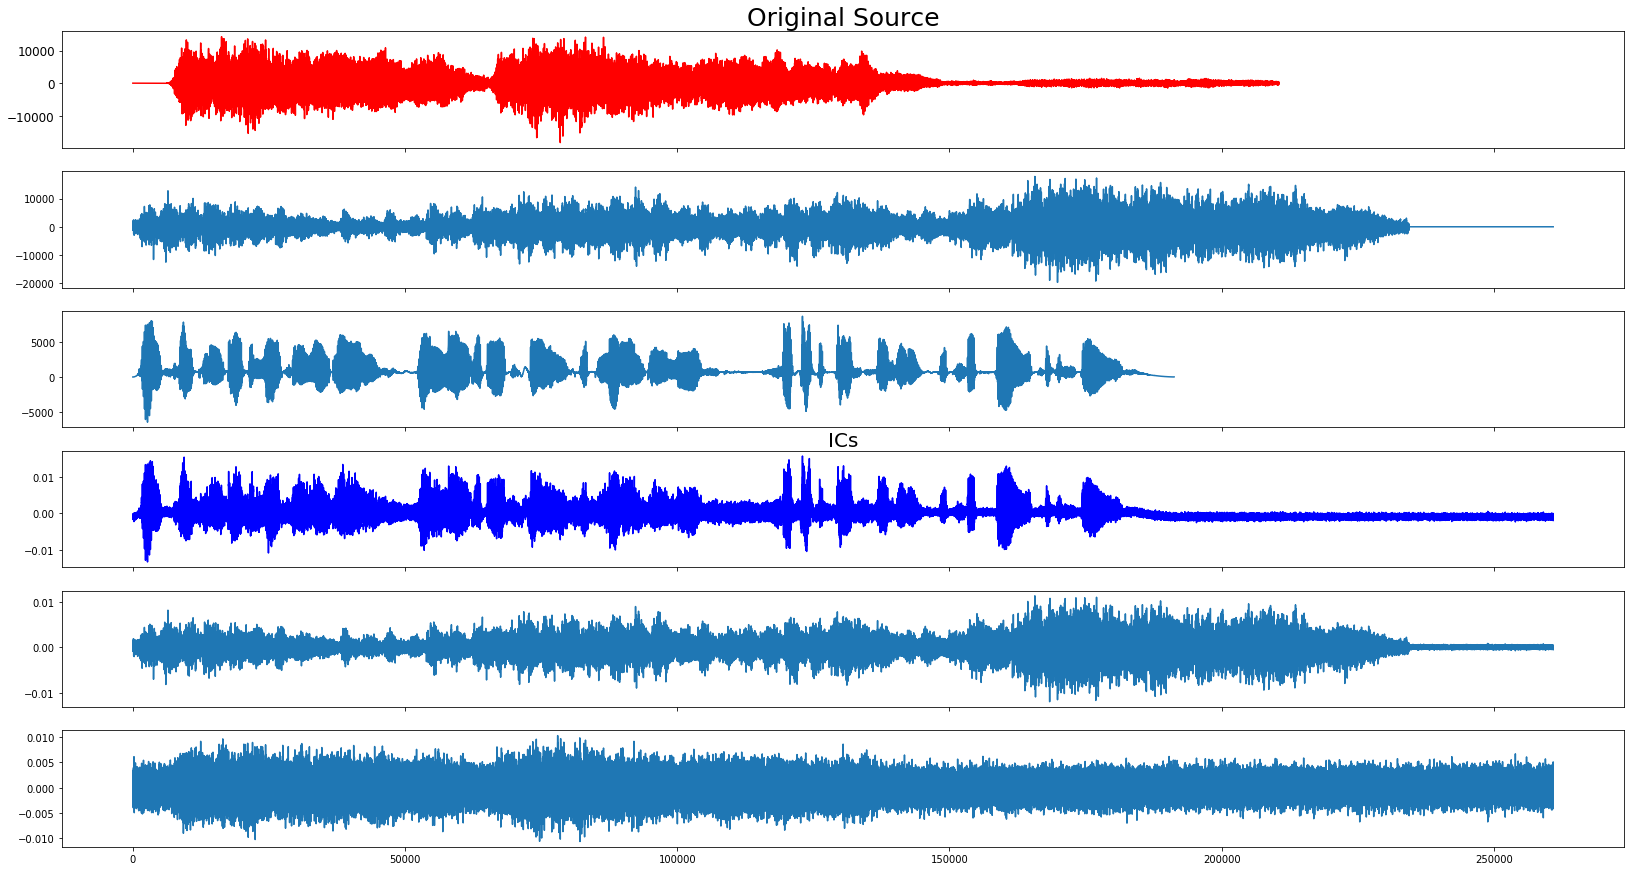

In [20]:
fig, ax = plt.subplots(6, 1, figsize=[28, 15], sharex=True)
ax[0].plot(source1,color='red')
ax[1].plot(source2)
ax[2].plot(source3)
ax[0].set_title('Original Source', fontsize=25)
ax[0].tick_params(labelsize=12)
ax[3].plot(S_[0],color='blue')
ax[4].plot(S_[1])
ax[5].plot(S_[2])
ax[2].set_xlabel('ICs', fontsize=20)